# Determinare il genere di alcuni autori Reddit in base ai loro commenti

### Autore: Davide Coppes

## Abstract
Lo scopo del progetto è quello di andare a predire il genere di alcuni utenti di Reddit, utilizzando un dataset con alcune migliaia di posts scritti da 5000 diversi autori. 
Per farlo si sono andati ad utilizzare diversi modelli di classificazione che sono stati allenati sul training set sia per i subreddits che per i posts scritti dagli autori. Come predizione del modello finale è stata effettuata una regressione lineare delle predizioni sull'ensemble set ottenute dai vari modelli.

### Indice

1. [Importazione dei dati](#importazione_dati)
1. [Preprocessing](#preprocessing)
    1. [Estrazione delle features dai subreddits](#subreddit_extraction)
    1. [Estrazione delle features dai posts](#text_extraction)
    1. [Creazione del dataset di training, di validazione e di ensemble](#dataset)
1. [Importazione dei dati di test ed estrazione delle features](#importazione_dati_test)
    1. [Estrazione delle features dai subreddits](#subreddit_extraction_test)
    1. [Estrazione delle features dai posts](#text_extraction_test)
1. [Selezione del modello](#model_selection)
    1. [Modelli sui subreddits](#model_subreddits)
        1. [Naive Bayes](#model_subreddits_NB)
            1. [Multinomial Naive Bayes](#model_subreddits_MNB)
            1. [Complement Naive Bayes](#model_subreddits_CNB)
        1. [Support Vector Machine](#model_subreddits_SVM)
            1. [Kernel RBF](#model_subreddits_SVM_rbf)
            1. [Kernel Lineare](#model_subreddits_SVM_lineare)
        1. [Logistic Regression](#model_subreddits_LR)
        1. [Random Forest](#model_subreddits_RF)
        1. [Multi-layer Perceptron](#model_subreddits_MLP)
    1. [Modelli sui posts](#model_posts)
        1. [Naive Bayes](#model_posts_NB)
            1. [Multinomial Naive Bayes](#model_posts_MNB)
            1. [Complement Naive Bayes](#model_posts_CNB)
        1. [Support Vector Machines](#model_posts_SVM)
        1. [Logistic Regression](#model_posts_LR)
        1. [Multi-layer Perceptron](#model_posts_MLP)
1. [Ensemble Model](#ensemble_model)
    1. [Subreddits](#ensemble_subreddits)
    1. [Posts](#ensemble_posts)
    1. [Ensemble](#ensemble_ensemble)

<a id='importazione_dati'></a>
# 1. Importazione dei dati

Il dataset usato riguarda 296042 posts di reddit scritti da 5000 autori diversi per 3468 subreddits.  

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
train_data = pd.read_csv("./data/train_data.csv", encoding="utf8")

In [4]:
train_data.head()

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [5]:
train_data.shape

(296042, 4)

In [6]:
target = pd.read_csv("./data/train_target.csv")

In [7]:
target.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


In [8]:
target.shape

(5000, 2)

In [9]:
target["gender"].value_counts()  # per contare numero di maschi 0 e femmine 1

0    3651
1    1349
Name: gender, dtype: int64

<a id='preprocessing'></a>
# 2. Preprocessing

Di seguito si riporta la parte di estrazione delle features effettuata sia sui subreddits che sui posts. Per questi ultimi è stato utilizzato bag of words.

<a id='subreddit_extraction'></a>
## 2.1 Subreddit Extraction

In [10]:
# Per contare il numero di subreddit
subreddits = train_data.subreddit.unique()

# Associa un indice ad ogni subreddit
subreddits_map = pd.Series(index=subreddits, data=np.arange(subreddits.shape[0]))

In [11]:
subreddits.shape

(3468,)

In [12]:
from scipy import sparse  # scrive le matrici in modo sparso

In [13]:
# Un gruppo indica l'insieme di tutti i subreddit di un autore
def extract_features(group):
    group_subreddits = group["subreddit"]
    group_subreddits = group_subreddits[
        group_subreddits.isin(subreddits_map.index)
    ].values
    idxs = subreddits_map.loc[group_subreddits].values
    v = sparse.dok_matrix((1, subreddits.shape[0]))
    for idx in idxs:
        if not np.isnan(idx):
            v[0, idx] = 1
    return v.tocsr()


extract_features(train_data[train_data.author == "RedThunder90"])

<1x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [14]:
features_dict = {}  # dizionario che associa ad ogni autore i subreddits che ha scritto

for author, group in train_data.groupby("author"):
    features_dict[author] = extract_features(group)

In [15]:
X_train_subreddit = sparse.vstack([features_dict[author] for author in target.author])
X_train_subreddit

<5000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 49152 stored elements in Compressed Sparse Row format>

In [16]:
y_train = target.gender
y_train

0       0
1       1
2       0
3       0
4       0
       ..
4995    0
4996    1
4997    0
4998    1
4999    0
Name: gender, Length: 5000, dtype: int64

<a id='text_extraction'></a>
## 2.2. Text Extraction 

In [17]:
# Tutto il testo scritto da un autore è estratto in una singola lista
def extract_text(group):
    group_text = group["body"].values
    return "".join(group_text)


extract_text(train_data[train_data.author == "RedThunder90"])

'I still prefer to buy foods either grown locally or where animals are treated better, but this definitely has me looking at organic food differently.'

In [18]:
text_dict = {}

for author, group in train_data.groupby("author"):
    text_dict[author] = extract_text(group)

In [19]:
author_text = [text_dict[author] for author in target.author]
authors_text = author_text

In [20]:
len(authors_text)

5000

#### Bag of words

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [22]:
pattern = "(?u)\\b[A-Za-z]{3,}"
# {3,} cerco tutte le parole con un minimo di 3 caratteri
# [A-Za-z] vuol dire con caratteri ammissibili dalla A alla Z maiuscole e dalla a alla z minuscole

stop_words = list(ENGLISH_STOP_WORDS)  # parole che non vogliamo conteggiare

vec = CountVectorizer(token_pattern=pattern, stop_words=stop_words, ngram_range=(1, 1))
C = vec.fit_transform(authors_text)  # lista dei messaggi che vogliamo vettorizzare

In [23]:
C

<5000x145545 sparse matrix of type '<class 'numpy.int64'>'
	with 2113335 stored elements in Compressed Sparse Row format>

In [24]:
# Normalizzazione
tfidf = TfidfTransformer()  # using log tf-idf

# Calculate features using tf-idf and create a training set
X_train_text = tfidf.fit_transform(C)

In [25]:
X_train_text.shape

(5000, 145545)

<a id='dataset'></a>
## 2.3. Creazione dei dataset di training, di validazione e di ensemble

Il dataset è stato diviso in tre parti: in un training set, usato per allenare i diversi modelli, in un validation set, usato per avere una stima di $E_{out}$ e in un ensemble set, usato come validation per il modello finale.

#### Subreddits data

In [26]:
rnd = 42  # random state
valid = 0.10
ensemble = 0.10

In [27]:
from sklearn.model_selection import train_test_split

(
    X_train_subreddit,
    X_valid_subreddit,
    y_train_subreddit,
    y_valid_subreddit,
) = train_test_split(X_train_subreddit, y_train, test_size=valid, random_state=rnd)

In [28]:
(
    X_train_subreddit,
    X_ens_subreddit,
    y_train_subreddit,
    y_ens_subreddit,
) = train_test_split(
    X_train_subreddit, y_train_subreddit, test_size=ensemble, random_state=rnd
)

In [29]:
print(np.shape(X_train_subreddit), np.shape(y_train_subreddit))
print(np.shape(X_valid_subreddit), np.shape(y_valid_subreddit))
print(np.shape(X_ens_subreddit), np.shape(y_ens_subreddit))

(4050, 3468) (4050,)
(500, 3468) (500,)
(450, 3468) (450,)


#### Text data

In [30]:
X_train_text, X_valid_text, y_train_text, y_valid_text = train_test_split(
    X_train_text, y_train, test_size=valid, random_state=rnd
)

In [31]:
X_train_text, X_ens_text, y_train_text, y_ens_text = train_test_split(
    X_train_text, y_train_text, test_size=ensemble, random_state=rnd
)

In [32]:
print(np.shape(X_train_text), np.shape(y_train_text))
print(np.shape(X_valid_text), np.shape(y_valid_text))
print(np.shape(X_ens_text), np.shape(y_ens_text))

(4050, 145545) (4050,)
(500, 145545) (500,)
(450, 145545) (450,)


<a id='importazione_dati_test'></a>
# 3. Importazione dei dati di test ed estrazione delle features

Di seguito si riporta l'importazione dei dati di test e l'estrazione delle features sia per i posts che per i subreddits con gli stessi metodi illustrati precedentemente per i dati di training.

In [33]:
test_data = pd.read_csv("./data2023/test_data.csv", encoding="utf8")

In [34]:
test_data.head()

,author,subreddit,created_utc,body
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
2,savoytruffle,AskReddit,1.388534e+09,bite me
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...


<a id='subreddit_extraction_test'></a>
## 3.1. Subreddit Extraction

In [35]:
features_test_dict = {}

for author, group in test_data.groupby("author"):
    features_test_dict[author] = extract_features(group)

In [36]:
X_test_subreddit = sparse.vstack(
    [features_test_dict[author] for author in test_data.author.unique()]
)
X_test_subreddit

<15000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 144898 stored elements in Compressed Sparse Row format>

<a id='text_extraction_test'></a>
## 3.2. Text Extraction

In [37]:
def extract_text(group):
    group_text = group["body"].values
    return "".join(group_text)

In [38]:
# Getting index positions of bad data in order to adjust it
def get_index_positions(list_of_elems, element):
    """Returns the indexes of all occurrences of give element in
    the list- listOfElements"""
    index_pos_list = []
    for i in range(len(list_of_elems)):
        if list_of_elems[i] == element:
            index_pos_list.append(i)
    return index_pos_list

In [39]:
# Some authors may happen to have null body text, and this results as an error in the text_test_dict cell
author_test_array = test_data["author"].values
author_test_list = author_test_array.tolist()

In [40]:
index_post_list = get_index_positions(author_test_list, "SketchingShibe")
print(
    "Indexes of all occurrences of {} in the list are : ".format("SketchingShibe"),
    index_post_list,
)

Indexes of all occurrences of SketchingShibe in the list are :  [7474, 7490, 12772, 13080, 18644, 29011, 31617, 31654, 31669, 37424, 37767, 39256, 39407, 46863, 47860, 53364, 54800, 54940, 55155, 55205, 55935, 67175, 67212, 67511, 69522, 71214, 71627, 163160, 175667, 194480, 204806, 221517, 221554, 221709, 223236, 229131, 298750, 307193, 307226, 389217, 477465, 477536, 479169, 481302, 481396, 492837, 498685, 499340, 499588, 500903, 538120, 539824, 540006, 652554, 655270, 658083, 669650, 672133, 677320, 687512, 717105, 742192, 742266, 742647, 775304, 786250, 799689, 799840, 805975, 812296, 946579, 947598, 953044, 953242, 953267, 956141, 968160, 968432, 970721, 982051, 982555, 983287, 985499, 985758, 986062, 1000589, 1001736, 1009923, 1021120, 1031064, 1032350, 1040183, 1044874, 1044920, 1045487, 1045518, 1060234, 1063169, 1063259, 1063323, 1072705, 1073019, 1073352, 1080933, 1100147, 1104379]


In [41]:
test_data = test_data.replace({np.nan: ","})

In [42]:
print(len(index_post_list))
test_data["body"].iloc[1063323]

106


','

In [43]:
text_test_dict = {}

for author, group in test_data.groupby("author"):
    text_test_dict[author] = extract_text(group)

In [44]:
author_test_text = [text_test_dict[author] for author in test_data.author.unique()]
authors_test_text = author_test_text

In [45]:
C_test = vec.transform(authors_test_text)

In [46]:
X_test_text = tfidf.transform(C_test)

In [47]:
X_test_text.shape

(15000, 145545)

<a id='model_selection'></a>
# 4. Selezione del modello

In totale si sono andati ad utilizzare 7 modelli:
   * multinomialNb
   * complementNB
   * Support Vector Machine con kernel RBF
   * Support Vector Machine con kernel lineare
   * Logistic Regression
   * Random Forest
   * Multi-layer Perceptron

#### Librerie

In [48]:
from sklearn import svm, model_selection
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#### Learning Curve

In [49]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")
    plt.show()
    return plt

#### Confusion matrix

In [50]:
def print_confusion_matrix(y_valid, y_pred_valid):
    # Calcola la matrice di confusione
    conf_matrix = confusion_matrix(y_valid, y_pred_valid)

    # Crea un DataFrame dalla matrice di confusione
    conf_df = pd.DataFrame(
        conf_matrix,
        index=["actual 0", "actual 1"],
        columns=["pred 0", "pred 1"],
    )

    # Crea una heatmap utilizzando Seaborn
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

<a id='model_subreddits'></a>
## 4.1 Modelli di classificazione sui subreddits

<a id='model_subreddits_NB'></a>
### 4.1.1. Naive Bayes sui subreddits

Il primo modello utilizzato è il Naive Bayes, sia Multinomial che Complement. Si è andati prima ad allenare il modello sul training set e poi in seguito si è andati ad ottimizzare l'iperparametro alpha per ottenerne il valore ottimale. Si è andati poi ad utilizzare il modello con il migliore valore di alpha per predire il genere degli autori del validation set e avere una prima stima dello score. Di seguito si possono visualizzare i risultati ottenuti.

<a id='model_subreddits_MNB'></a>
#### 4.1.1.1. Multinomial Naive Bayes

#### GridSearch mNB

In [51]:
hyprm_alphas = np.logspace(-2, 0, 100)

param_grid = {"alpha": hyprm_alphas}
model = MultinomialNB()

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = model_selection.GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv
)
gs.fit(X_train_subreddit, y_train_subreddit)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'alpha': 0.37649358067924693}


In [52]:
mNB_subreddit = gs.best_estimator_
mNB_subreddit

MultinomialNB(alpha=0.37649358067924693)

#### Soluzione sul validation set

In [53]:
y_pred_valid = mNB_subreddit.predict(X_valid_subreddit)
print("mNB - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_subreddit, y_pred_valid), 4))

mNB - Estimate of E_out
ROC-Score:  0.7949


#### Confusion Matrix

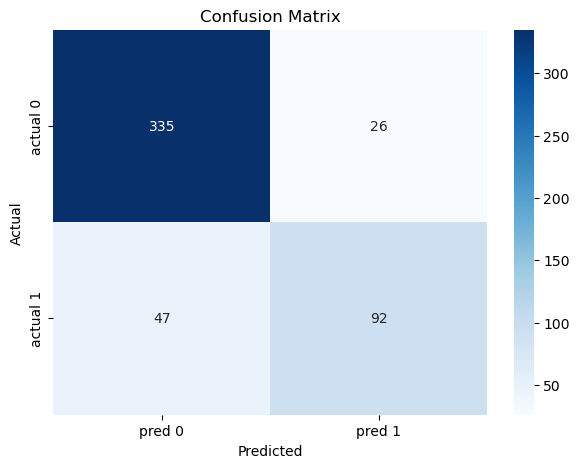

In [54]:
print_confusion_matrix(y_valid_subreddit, y_pred_valid)

#### Learning curve

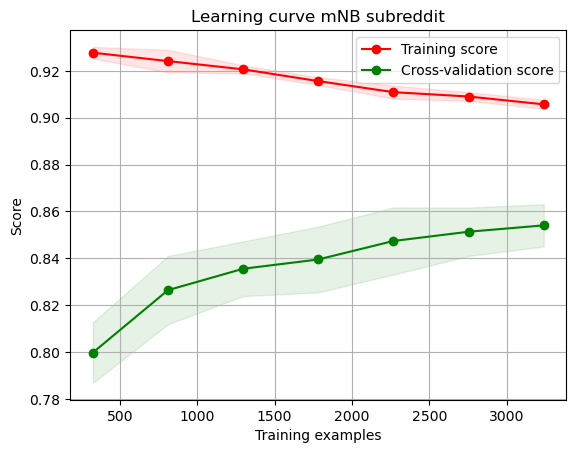

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [55]:
title = "Learning curve mNB subreddit"
plot_learning_curve(
    mNB_subreddit,
    title,
    X_train_subreddit,
    y_train_subreddit,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 7),
)

#### Soluzione del modello mNB

In [56]:
y_pred = mNB_subreddit.predict_proba(X_test_subreddit)[:, 1]

In [57]:
solution_mNB_subreddit = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_pred}
)
solution_mNB_subreddit.head()

,author,gender
0,ejchristian86,1.000000e+00
1,ZenDragon,1.109127e-09
2,savoytruffle,1.012729e-04
3,hentercenter,4.411620e-03
4,rick-o-suave,9.228842e-02


In [58]:
# solution_mNB_subreddit.to_csv("solution_mNB_subreddit.csv", index=False)

<a id='model_subreddits_CNB'></a>
#### 4.1.1.2. Complement Naive Bayes

Complement Naive Bayes, anche in questo caso si andati ad ottimizzare l'iperparametro alpha.

#### GridSearch cNB

In [59]:
hyprm_alphas = np.logspace(-1, 0, 100)

param_grid = {"alpha": hyprm_alphas}
model = ComplementNB()

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = model_selection.GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv
)
gs.fit(X_train_subreddit, y_train_subreddit)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'alpha': 0.38535285937105296}


In [60]:
cNB_subreddit = gs.best_estimator_
cNB_subreddit

ComplementNB(alpha=0.38535285937105296)

#### Soluzione sul validation set

In [61]:
y_pred_valid = cNB_subreddit.predict(X_valid_subreddit)
print("cNB - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_subreddit, y_pred_valid), 4))

cNB - Estimate of E_out
ROC-Score:  0.8416


#### Confusion Matrix

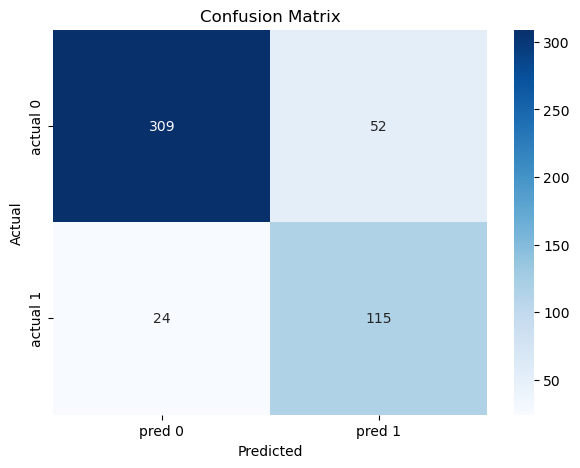

In [62]:
print_confusion_matrix(y_valid_subreddit, y_pred_valid)

#### Learning curve

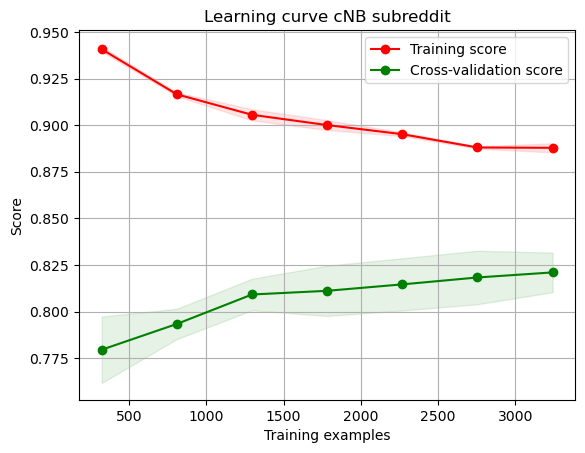

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [63]:
title = "Learning curve cNB subreddit"
plot_learning_curve(
    cNB_subreddit,
    title,
    X_train_subreddit,
    y_train_subreddit,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 7),
)

#### Soluzione del modello cNB

In [64]:
y_pred = cNB_subreddit.predict_proba(X_test_subreddit)[:, 1]

In [65]:
solution_cNB_subreddit = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_pred}
)
solution_cNB_subreddit.head()

,author,gender
0,ejchristian86,1.000000e+00
1,ZenDragon,3.284800e-09
2,savoytruffle,2.946958e-04
3,hentercenter,1.301250e-02
4,rick-o-suave,2.206143e-01


In [66]:
# solution_cNB_subreddit.to_csv("solution_cNB_subreddit.csv", index=False)

<a id='model_subreddits_SVM'></a>
### 4.1.2. Support Vector Machine per i subreddits

Il secondo modello utilizzato è SVM con kernel rfb e lineare. Anche in questo caso si sono cercati i valori migliori per gli iperparametri gamma (solo RBF) e C. Per gamma grandi la complessità del modello aumenta con conseguente rischio che possa avvenire overfitting, al contrario per gamma piccoli potrebbe avvenire underfitting. Allo stesso modo è stato valutato il parametro C che regola il confine tra margine soft ed hard.

<a id='model_subreddits_SVM_rbf'></a>
#### 4.1.2.1. Kernel RBF

#### Grid Search SVM

In [67]:
param_C = np.logspace(math.log10(5), math.log10(20), 15)
param_gamma = np.logspace(math.log10(0.005), math.log10(0.05), 15)

param_grid = {"C": param_C, "gamma": param_gamma}
model = svm.SVC(kernel="rbf", probability=True)

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = model_selection.GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv
)
gs.fit(X_train_subreddit, y_train_subreddit)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'C': 11.59491881803038, 'gamma': 0.01}


In [68]:
SVM_subreddit = gs.best_estimator_
SVM_subreddit

SVC(C=11.59491881803038, gamma=0.01, probability=True)

#### Soluzione sul validation set

In [69]:
y_pred_valid = SVM_subreddit.predict(X_valid_subreddit)
print("SVM - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_subreddit, y_pred_valid), 4))

SVM - Estimate of E_out
ROC-Score:  0.7393


#### Confusion Matrix

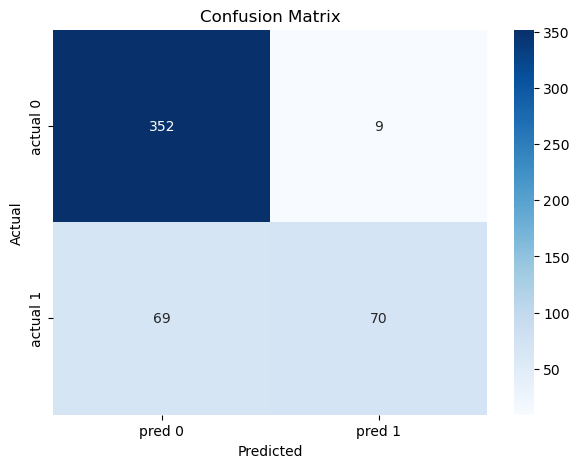

In [70]:
print_confusion_matrix(y_valid_subreddit, y_pred_valid)

#### Learning curve

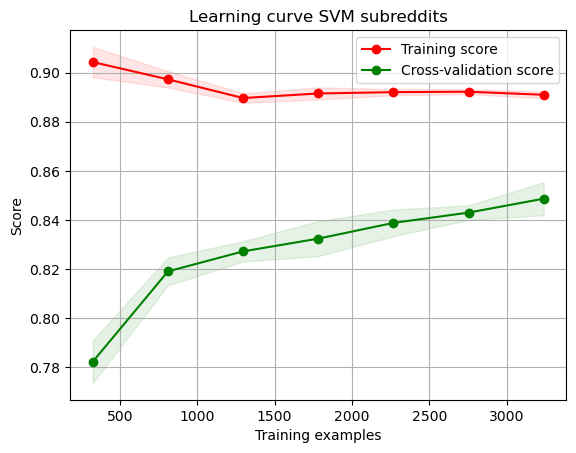

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [71]:
title = "Learning curve SVM subreddits"
plot_learning_curve(
    SVM_subreddit,
    title,
    X_train_subreddit,
    y_train_subreddit,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 7),
)

#### Soluzione del modello SVM 

In [72]:
y_pred = SVM_subreddit.predict_proba(X_test_subreddit)[:, 1]

In [73]:
solution_SVM_subreddit = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_pred}
)
solution_SVM_subreddit.head()

,author,gender
0,ejchristian86,1.000000
1,ZenDragon,0.017407
2,savoytruffle,0.032664
3,hentercenter,0.164806
4,rick-o-suave,0.193668


In [74]:
# solution_SVM_subreddit.to_csv("solution_SVM_subreddit.csv", index=False)

<a id='model_subreddits_SVM_lineare'></a>
#### 4.1.2.2. Kernel Lineare

#### Grid Search SVM

In [75]:
param_C = np.logspace(-1, 1, 15)

param_grid = {"C": param_C}
model = svm.SVC(kernel="linear", probability=True)

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = model_selection.GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv
)
gs.fit(X_train_subreddit, y_train_subreddit)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'C': 0.2682695795279726}


In [76]:
lSVM_subreddit = gs.best_estimator_
lSVM_subreddit

SVC(C=0.2682695795279726, kernel='linear', probability=True)

#### Soluzione sul validation set

In [77]:
y_pred_valid = lSVM_subreddit.predict(X_valid_subreddit)
print("lSVM - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_subreddit, y_pred_valid), 4))

lSVM - Estimate of E_out
ROC-Score:  0.733


#### Confusion Matrix

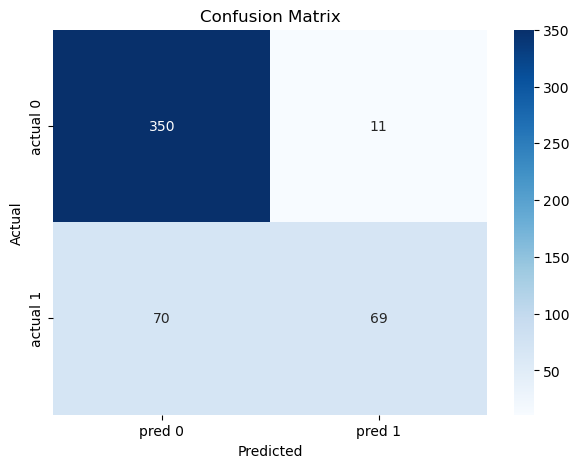

In [78]:
print_confusion_matrix(y_valid_subreddit, y_pred_valid)

#### Learning curve

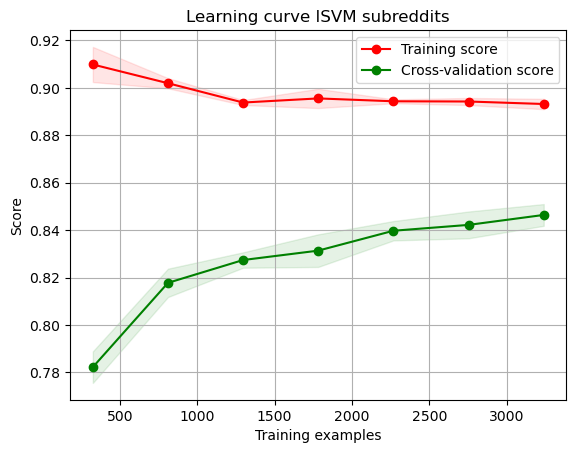

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [79]:
title = "Learning curve lSVM subreddits"
plot_learning_curve(
    lSVM_subreddit,
    title,
    X_train_subreddit,
    y_train_subreddit,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 7),
)

#### Soluzione del modello SVM 

In [80]:
y_pred = lSVM_subreddit.predict_proba(X_test_subreddit)[:, 1]

In [81]:
solution_lSVM_subreddit = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_pred}
)
solution_lSVM_subreddit.head()

,author,gender
0,ejchristian86,1.000000
1,ZenDragon,0.018980
2,savoytruffle,0.028658
3,hentercenter,0.201063
4,rick-o-suave,0.217731


In [82]:
# solution_lSVM_subreddit.to_csv("solution_lSVM_subreddit.csv", index=False)

<a id='model_subreddits_LR'></a>
### 4.1.3. Logistic Regression per i subreddit

Il terzo modello usato è quello della regressione logisitca. In questo caso si è andati a cercare il migliore valore per l'iperparametro C. Più piccolo è C più forte è la regolarizzazione. Di seguito si mostrano i risultati ottenuti.

#### Grid Search LR

In [83]:
param_C = np.logspace(-1, 1, 100)

param_grid = {"C": param_C}
model = LogisticRegression(max_iter=1000)

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = model_selection.GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv
)
gs.fit(X_train_subreddit, y_train_subreddit)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'C': 0.7906043210907697}


In [84]:
LR_subreddit = gs.best_estimator_
LR_subreddit

LogisticRegression(C=0.7906043210907697, max_iter=1000)

#### Soluzione sul validation set

In [85]:
y_pred_valid = LR_subreddit.predict(X_valid_subreddit)
print("LR - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_subreddit, y_pred_valid), 4))

LR - Estimate of E_out
ROC-Score:  0.7587


#### Confusion Matrix

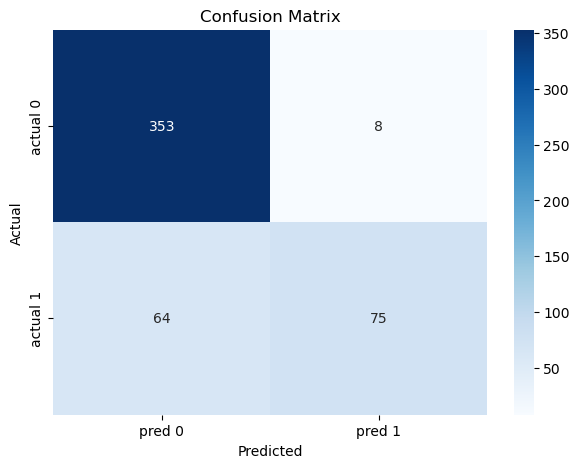

In [86]:
print_confusion_matrix(y_valid_subreddit, y_pred_valid)

#### Learning curve

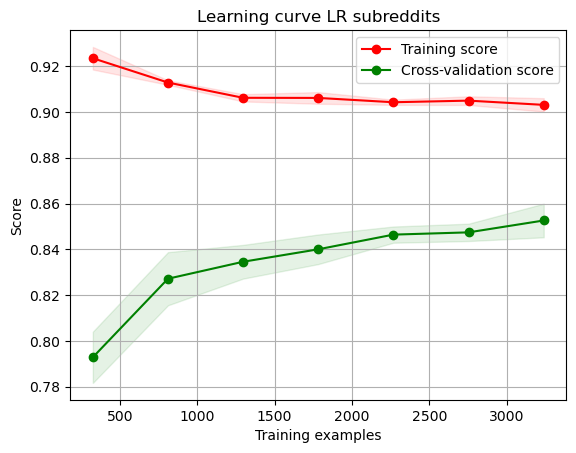

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [87]:
title = "Learning curve LR subreddits"
plot_learning_curve(
    LR_subreddit,
    title,
    X_train_subreddit,
    y_train_subreddit,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 7),
)

#### Soluzione del modello LR

In [88]:
y_pred = LR_subreddit.predict_proba(X_test_subreddit)[:, 1]

In [89]:
solution_LR_subreddit = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_pred}
)
solution_LR_subreddit.head()

,author,gender
0,ejchristian86,0.999946
1,ZenDragon,0.003553
2,savoytruffle,0.016221
3,hentercenter,0.145371
4,rick-o-suave,0.288561


In [90]:
# solution_LR_subreddit.to_csv("solution_LR_subreddit.csv", index=False)

<a id='model_subreddits_RF'></a>
### 4.1.4. Random Forest per i subreddit

Il quarto modello usato è Random Forest. In questo caso si è andati a cercare i migliori valori per gli iperparametri "criterion" e numero di decision tree.

#### Grid Search RF

In [91]:
param_estimators = [int(n) for n in np.arange(30, 100, 10)]
param_criterion = ["gini", "log_loss", "entropy"]

param_grid = {"n_estimators": param_estimators, "criterion": param_criterion}
model = RandomForestClassifier()

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = model_selection.GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv
)
gs.fit(X_train_subreddit, y_train_subreddit)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'criterion': 'entropy', 'n_estimators': 40}


In [92]:
RF_subreddit = gs.best_estimator_
RF_subreddit

RandomForestClassifier(criterion='entropy', n_estimators=40)

#### Soluzione sul validation set

In [93]:
y_pred_valid = RF_subreddit.predict(X_valid_subreddit)
print("RF - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_subreddit, y_pred_valid), 4))

RF - Estimate of E_out
ROC-Score:  0.7382


#### Confusion Matrix

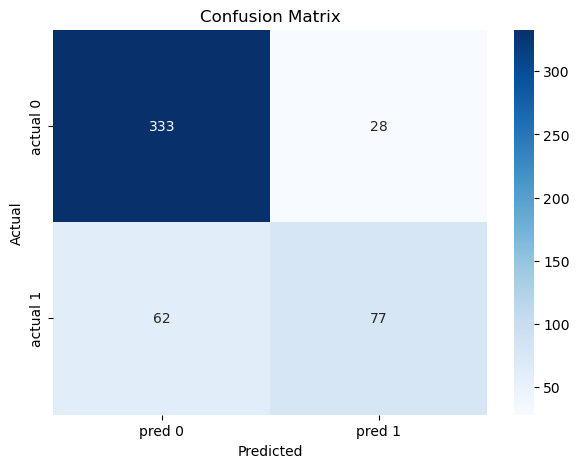

In [94]:
print_confusion_matrix(y_valid_subreddit, y_pred_valid)

#### Learning curve

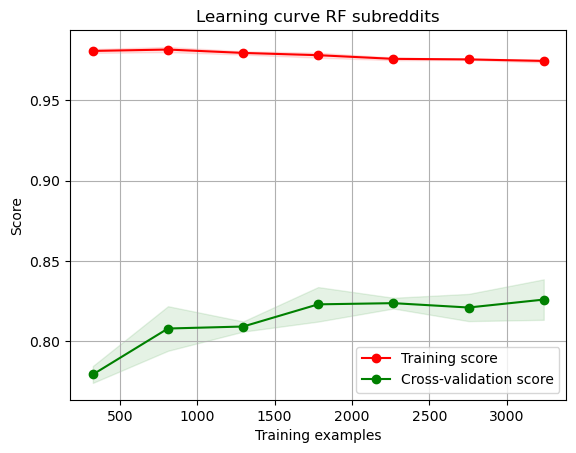

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [95]:
title = "Learning curve RF subreddits"
plot_learning_curve(
    RF_subreddit,
    title,
    X_train_subreddit,
    y_train_subreddit,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 7),
)

#### Soluzione del modello RF

In [96]:
y_pred = RF_subreddit.predict_proba(X_test_subreddit)[:, 1]

In [97]:
solution_RF_subreddit = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_pred}
)
solution_RF_subreddit.head()

,author,gender
0,ejchristian86,0.850000
1,ZenDragon,0.025000
2,savoytruffle,0.145833
3,hentercenter,0.354167
4,rick-o-suave,0.440617


In [98]:
# solution_RF_subreddit.to_csv("solution_RF_subreddit.csv", index=False)

<a id='model_subreddits_MLP'></a>
### 4.1.6. Multi-layer Perceptron per i subreddit

L'ultimo modello usato è MLP; gli iperparametri che siamo andati a testare sono il numero di neuroni nell'hidden layer e alpha, il parametro relativo alla regolarizzazione L2.

#### GridSearch MLP

In [99]:
param_alpha = np.logspace(-7, -3, 5)
param_hidden_layer_sizes = [(int(n),) for n in np.linspace(90, 130, 15)]

param_grid = {"alpha": param_alpha, "hidden_layer_sizes": param_hidden_layer_sizes}
model = MLPClassifier(early_stopping=True)

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv)
gs.fit(X_train_subreddit, y_train_subreddit)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'alpha': 1e-05, 'hidden_layer_sizes': (117,)}


In [100]:
MLP_subreddit = gs.best_estimator_
MLP_subreddit

MLPClassifier(alpha=1e-05, early_stopping=True, hidden_layer_sizes=(117,))

#### Soluzione sul validation set

In [101]:
y_pred_valid = MLP_subreddit.predict(X_valid_subreddit)
print("MLP - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_subreddit, y_pred_valid), 4))

MLP - Estimate of E_out
ROC-Score:  0.7806


#### Confusion Matrix

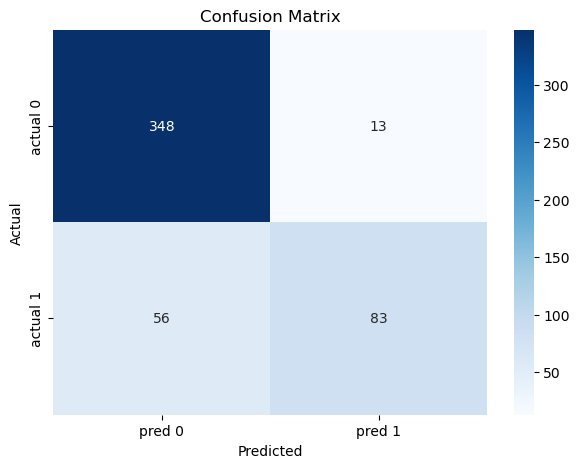

In [102]:
print_confusion_matrix(y_valid_subreddit, y_pred_valid)

#### Learning curve

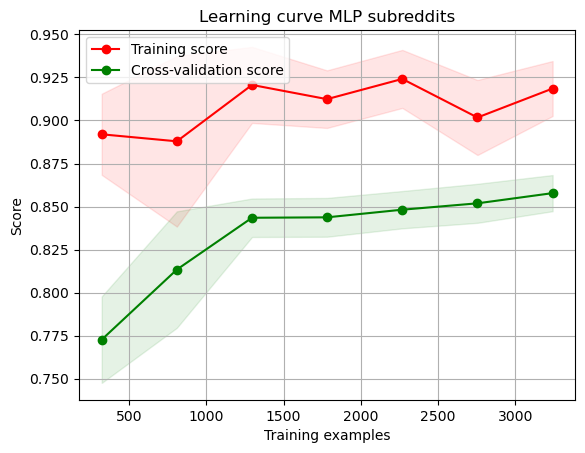

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [103]:
title = "Learning curve MLP subreddits"
plot_learning_curve(
    MLP_subreddit,
    title,
    X_train_subreddit,
    y_train_subreddit,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 7),
)

#### Soluzione del modello MLP

In [104]:
y_pred = MLP_subreddit.predict_proba(X_test_subreddit)[:, 1]

In [105]:
solution_MLP_subreddit = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_pred}
)
solution_MLP_subreddit.head()

,author,gender
0,ejchristian86,0.999058
1,ZenDragon,0.000819
2,savoytruffle,0.016184
3,hentercenter,0.025766
4,rick-o-suave,0.225363


In [106]:
# solution_MLP_subreddit.to_csv("solution_MLP_subreddit.csv", index=False)

<a id='model_posts'></a>
## 4.2 Modelli di classificazione sui posts

Di seguito si riportano gli stessi modelli precedentemente utilizzati, ma che sono stati allenati sulle features estratte dai posts.

<a id='model_posts_NB'></a>
### 4.2.1. Naive Bayes per i posts

<a id='model_posts_MNB'></a>
#### 4.2.1.1. Multinomial Naive Bayes per i posts

#### GridSearch mNB

In [107]:
param_alphas = np.logspace(-2, -1, 50)

param_grid = {"alpha": param_alphas}
model = MultinomialNB()

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = model_selection.GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv
)
gs.fit(X_train_text, y_train_text)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'alpha': 0.011513953993264475}


In [108]:
mNB_text = gs.best_estimator_
mNB_text

MultinomialNB(alpha=0.011513953993264475)

#### Soluzione sul validation set

In [109]:
y_pred_valid = mNB_text.predict(X_valid_text)
print("mNB - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_text, y_pred_valid), 4))

mNB - Estimate of E_out
ROC-Score:  0.7523


#### Confusion Matrix

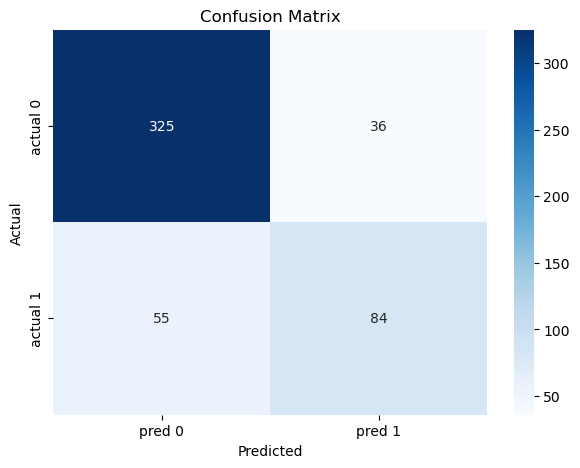

In [110]:
print_confusion_matrix(y_valid_text, y_pred_valid)

#### Learning curve

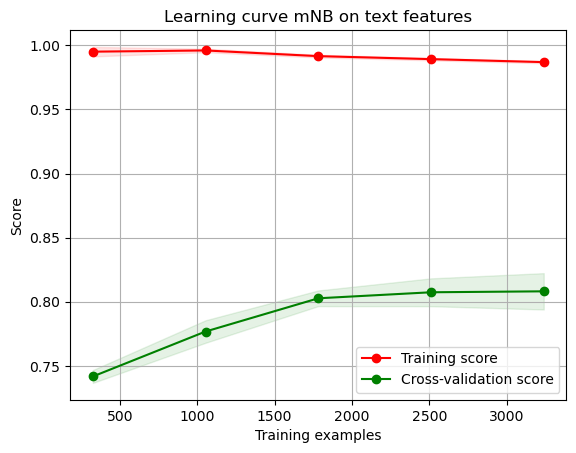

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [111]:
title = "Learning curve mNB on text features"
plot_learning_curve(
    mNB_text,
    title,
    X_train_text,
    y_train_text,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 5),
)

#### Soluzione del modello mNB

In [112]:
y_pred = mNB_text.predict_proba(X_test_text)[:, 1]

In [113]:
solution_mNB_text = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_pred}
)
solution_mNB_text.head()

,author,gender
0,ejchristian86,0.979276
1,ZenDragon,0.000176
2,savoytruffle,0.000104
3,hentercenter,0.007012
4,rick-o-suave,0.039572


In [114]:
# solution_mNB_text.to_csv("solution_mNB_posts.csv", index=False)

<a id='model_posts_CNB'></a>
#### 4.2.1.2. Complement Naive Bayes per i posts

#### GridSearch cNB

In [115]:
param_alphas = np.logspace(-2, -1, 50)

param_grid = {"alpha": param_alphas}
model = ComplementNB()

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = model_selection.GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv
)
gs.fit(X_train_text, y_train_text)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'alpha': 0.011513953993264475}


In [116]:
cNB_text = gs.best_estimator_
cNB_text

ComplementNB(alpha=0.011513953993264475)

#### Soluzione sul validation set

In [117]:
y_pred_valid = cNB_text.predict(X_valid_text)
print("cNB - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_text, y_pred_valid), 4))

cNB - Estimate of E_out
ROC-Score:  0.7674


#### Confusion Matrix

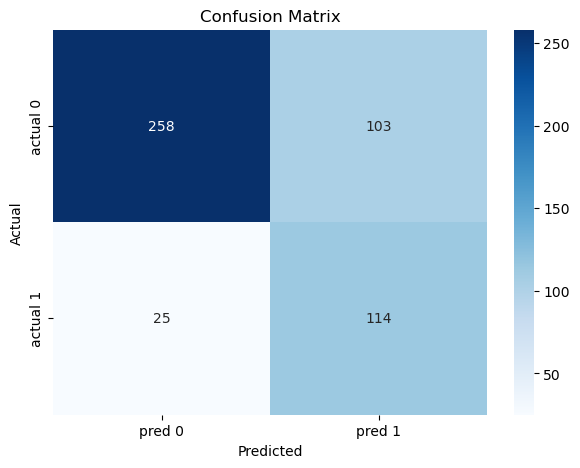

In [118]:
print_confusion_matrix(y_valid_text, y_pred_valid)

#### Learning curve

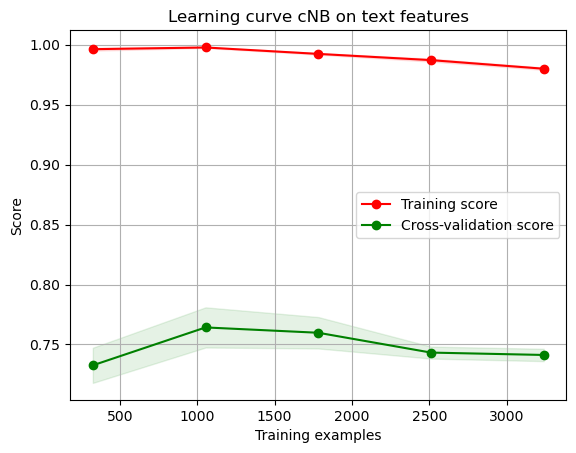

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [119]:
title = "Learning curve cNB on text features"
plot_learning_curve(
    cNB_text,
    title,
    X_train_text,
    y_train_text,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 5),
)

#### Soluzione del modello cNB 

In [120]:
y_pred = cNB_text.predict_proba(X_test_text)[:, 1]

In [121]:
solution_cNB_text = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_pred}
)
solution_cNB_text.head()

,author,gender
0,ejchristian86,0.992325
1,ZenDragon,0.000480
2,savoytruffle,0.000283
3,hentercenter,0.018955
4,rick-o-suave,0.101314


In [122]:
# solution_cNB_text.to_csv("solution_cNB_posts.csv", index=False)

<a id='model_posts_SVM'></a>
### 4.2.3. Support Vector Machines per i posts

Con kernel lineare.

#### GridSearch SVM

In [123]:
param_C = np.logspace(0, 1, 3)

param_grid = {"C": param_C}
model = svm.SVC(kernel="linear", probability=True)

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = model_selection.GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv
)
gs.fit(X_train_text, y_train_text)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'C': 1.0}


In [124]:
SVM_text = gs.best_estimator_
SVM_text

SVC(kernel='linear', probability=True)

#### Soluzione sul validation set

In [125]:
y_pred_valid = SVM_text.predict(X_valid_text)
print("SVM - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_text, y_pred_valid), 4))

SVM - Estimate of E_out
ROC-Score:  0.7283


#### Confusion Matrix

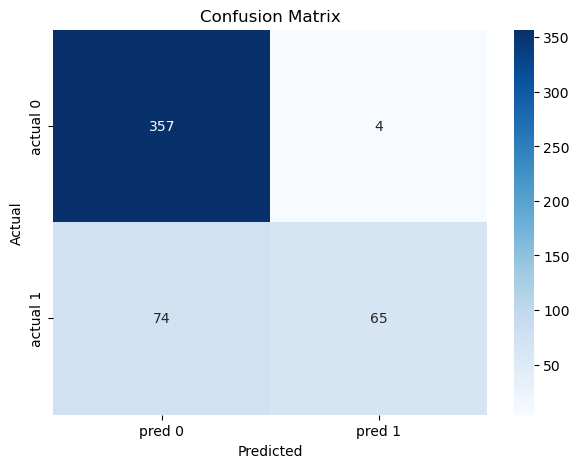

In [126]:
print_confusion_matrix(y_valid_text, y_pred_valid)

#### Learning curve

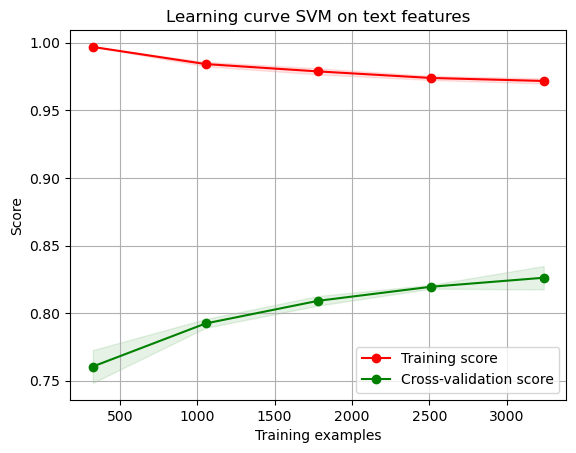

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [127]:
title = "Learning curve SVM on text features"
plot_learning_curve(
    SVM_text,
    title,
    X_train_text,
    y_train_text,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 5),
)

#### Soluzione del modello SVM

In [128]:
y_pred = SVM_text.predict_proba(X_test_text)[:, 1]

In [129]:
solution_SVM_text = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_pred}
)
solution_SVM_text.head()

,author,gender
0,ejchristian86,0.984579
1,ZenDragon,0.028127
2,savoytruffle,0.023119
3,hentercenter,0.110878
4,rick-o-suave,0.132264


In [130]:
# solution_SVM_text.to_csv("solution_SVM_posts.csv", index=False)

<a id='model_posts_LR'></a>
### 4.2.4. Logicric Regression per i posts

#### GridSearch LR

In [131]:
param_C = np.logspace(0, 1, 25)

param_grid = {"C": param_C}
model = LogisticRegression(max_iter=1000)

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = model_selection.GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv
)
gs.fit(X_train_text, y_train_text)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'C': 2.329951810515372}


In [132]:
LR_text = gs.best_estimator_
LR_text

LogisticRegression(C=2.329951810515372, max_iter=1000)

#### Soluzione sul validation set

In [133]:
y_pred_valid = LR_text.predict(X_valid_text)
print("LR - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_text, y_pred_valid), 4))

LR - Estimate of E_out
ROC-Score:  0.6649


#### Confusion Matrix

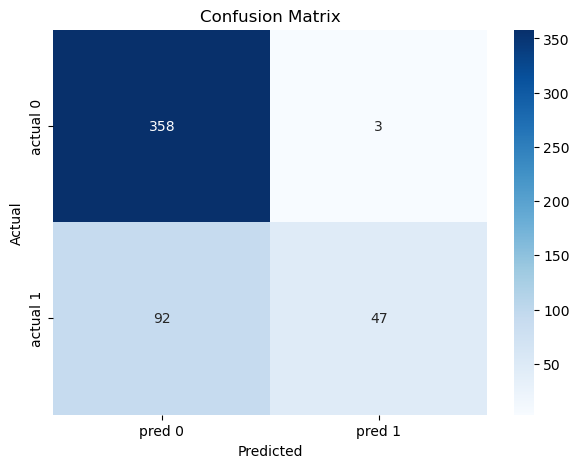

In [134]:
print_confusion_matrix(y_valid_text, y_pred_valid)

#### Learning curve

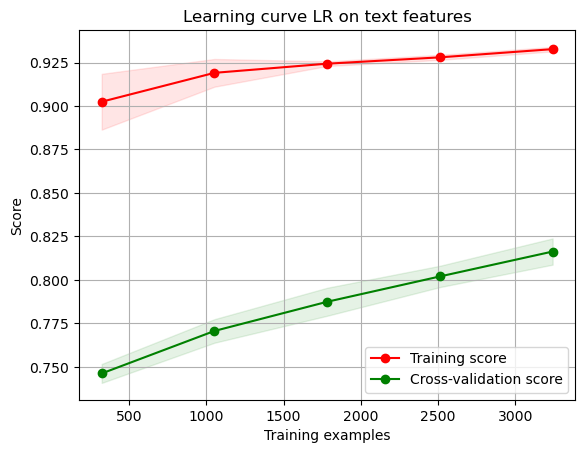

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [135]:
title = "Learning curve LR on text features"
plot_learning_curve(
    LR_text,
    title,
    X_train_text,
    y_train_text,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 5),
)

#### Soluzione del modello LR

In [136]:
y_pred = LR_text.predict_proba(X_test_text)[:, 1]

In [137]:
solution_LR_text = pd.DataFrame({"author": test_data.author.unique(), "gender": y_pred})
solution_LR_text.head()

,author,gender
0,ejchristian86,0.747100
1,ZenDragon,0.056629
2,savoytruffle,0.064953
3,hentercenter,0.162375
4,rick-o-suave,0.181214


In [138]:
# solution_LR_text.to_csv("solution_LR_posts.csv", index=False)

<a id='model_posts_MLP'></a>
### 4.2.5. Multi-layer Perceptron per i posts

#### GridSearch RF

In [147]:
param_alpha = np.logspace(-7, 2, 10)
hidden_layer_sizes = (100,)

param_grid = {"alpha": param_alpha}
model = MLPClassifier(early_stopping=True)

cv = KFold(n_splits=10, shuffle=True, random_state=0)
gs = model_selection.GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv
)
gs.fit(X_train_text, y_train_text)

# I migliori iperparametri
best_params = gs.best_params_
print("I migliori iperparametri:", best_params)

{'alpha': 0.01}


In [148]:
MLP_text = gs.best_estimator_
MLP_text

MLPClassifier(alpha=0.01, early_stopping=True)

#### Soluzione sul validation set

In [149]:
y_pred_valid = MLP_text.predict(X_valid_text)
print("MLP - Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_text, y_pred_valid), 4))

MLP - Estimate of E_out
ROC-Score:  0.7446


#### Confusion Matrix

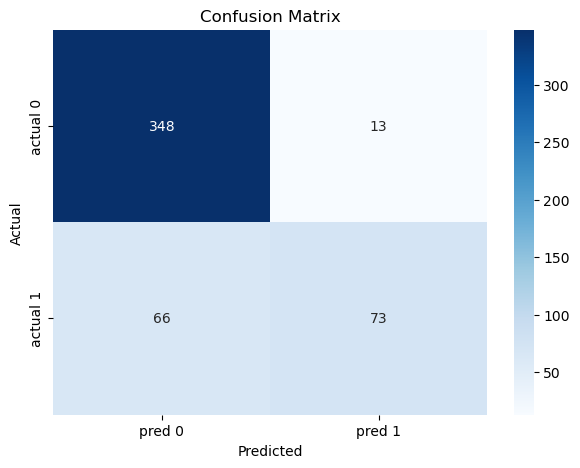

In [150]:
print_confusion_matrix(y_valid_text, y_pred_valid)

#### Learning curve

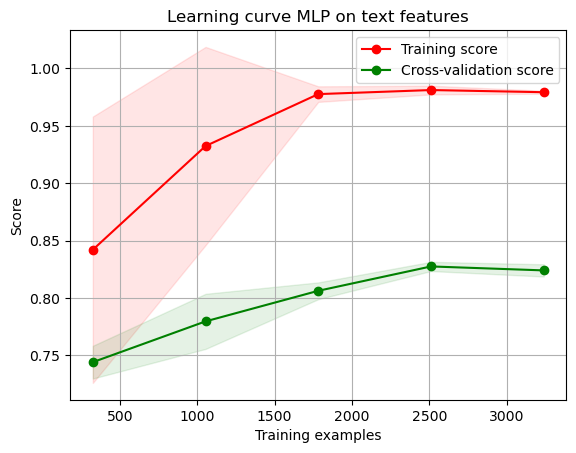

<module 'matplotlib.pyplot' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [151]:
title = "Learning curve MLP on text features"
plot_learning_curve(
    MLP_text,
    title,
    X_train_text,
    y_train_text,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 5),
)

#### Soluzione del modello MLP

In [152]:
y_pred = MLP_text.predict_proba(X_test_text)[:, 1]

In [153]:
solution_MLP_text = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_pred}
)
solution_MLP_text.head()

,author,gender
0,ejchristian86,0.863709
1,ZenDragon,0.007426
2,savoytruffle,0.003199
3,hentercenter,0.080597
4,rick-o-suave,0.109603


In [154]:
# solution_MLP_text.to_csv("solution_MLP_posts.csv", index=False)

<a id='ensemble_model'></a>
# 5. Ensemble Model

Andiamo ora ad unire tutti questi modelli. Prima facciamo un'unica predizione per i subreddits e una per i posts, poi andremo ad unire anche queste due, così da ottenere la predizione finale.

In [155]:
from sklearn.ensemble import StackingClassifier

<a id='ensemble_subreddits'></a>
## 5.1 Subreddits

In [156]:
subreddit_models = [
    ("mNB", mNB_subreddit),
    ("cNB", cNB_subreddit),
    ("SVM", SVM_subreddit),
    ("lSVM", lSVM_subreddit),
    ("LR", LR_subreddit),
    ("RF", RF_subreddit),
    ("MLP", MLP_subreddit),
]

In [157]:
subreddit_stacking = StackingClassifier(
    estimators=subreddit_models, final_estimator=LogisticRegression()
)

In [158]:
subreddit_stacking.fit(X_train_subreddit, y_train_subreddit)

StackingClassifier(estimators=[('mNB',
                                MultinomialNB(alpha=0.37649358067924693)),
                               ('cNB', ComplementNB(alpha=0.38535285937105296)),
                               ('SVM',
                                SVC(C=11.59491881803038, gamma=0.01,
                                    probability=True)),
                               ('lSVM',
                                SVC(C=0.2682695795279726, kernel='linear',
                                    probability=True)),
                               ('LR',
                                LogisticRegression(C=0.7906043210907697,
                                                   max_iter=1000)),
                               ('RF',
                                RandomForestClassifier(criterion='entropy',
                                                       n_estimators=40)),
                               ('MLP',
                                MLPClassifier(alpha=1e-05, early_stopping=True,
                                              hidden_layer_sizes=(117,)))],
                   final_estimator=LogisticRegression())

In [159]:
y_pred_subreddit = subreddit_stacking.predict_proba(X_test_subreddit)[:, 1]

In [160]:
y_pred_valid = subreddit_stacking.predict(X_valid_subreddit)
print("Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_subreddit, y_pred_valid), 4))

Estimate of E_out
ROC-Score:  0.8154


<a id='ensemble_posts'></a>
## 5.2 Posts

In [173]:
text_models = [
    ("mNB", mNB_text),
    ("cNB", cNB_text),
    ("SVM", SVM_text),
    ("LR", LR_text),
    ("MLP", MLP_text),
]

In [174]:
text_stacking = StackingClassifier(
    estimators=text_models, final_estimator=LogisticRegression()
)

In [175]:
text_stacking.fit(X_train_text, y_train_text)

StackingClassifier(estimators=[('mNB',
                                MultinomialNB(alpha=0.011513953993264475)),
                               ('cNB',
                                ComplementNB(alpha=0.011513953993264475)),
                               ('SVM', SVC(kernel='linear', probability=True)),
                               ('LR',
                                LogisticRegression(C=2.329951810515372,
                                                   max_iter=1000)),
                               ('MLP',
                                MLPClassifier(alpha=0.01,
                                              early_stopping=True))],
                   final_estimator=LogisticRegression())

In [176]:
y_pred_text = text_stacking.predict_proba(X_test_text)[:, 1]

In [177]:
y_pred_valid = text_stacking.predict(X_valid_text)
print("Estimate of E_out")
print("ROC-Score: ", round(roc_auc_score(y_valid_text, y_pred_valid), 4))

Estimate of E_out
ROC-Score:  0.7698


<a id='ensemble_ensemble'></a>
## 5.3 Ensemble

Andiamo a cercare i pesi ottimali relativi alla combinazione lineare delle due predizioni.

In [178]:
weig = [round(x * 0.01, 2) for x in range(1, 100)]
weights_combinations = [(w, 1 - w) for w in weig]

best_score = 0.0
best_weights = None

for weights in weights_combinations:
    # Calcola il risultato combinato usando i pesi
    y_pred_subreddit = subreddit_stacking.predict_proba(X_ens_subreddit)[:, 1]
    y_pred_text = text_stacking.predict_proba(X_ens_text)[:, 1]

    y_pred_combined = weights[0] * y_pred_subreddit + weights[1] * y_pred_text

    # Calcola lo score usando roc_auc_score
    score = roc_auc_score(y_ens_subreddit, y_pred_combined)

    # Verifica se lo score attuale è migliore del miglior score precedente
    if score > best_score:
        best_score = score
        best_weights = weights

weights = [
    round(w, 2) for w in best_weights
]  # Pesi per le previsioni dei subreddit e del testo

print("Miglior score:", best_score)
print("Migliori pesi:", weights)

Miglior score: 0.9246276699980402
Migliori pesi: [0.63, 0.37]


In [179]:
y_pred_subreddit = subreddit_stacking.predict_proba(X_test_subreddit)[:, 1]
y_pred_text = text_stacking.predict_proba(X_test_text)[:, 1]

In [180]:
y_test_ensemble = weights[0] * y_pred_subreddit + weights[1] * y_pred_text

In [181]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_test_ensemble = scaler.fit_transform(y_test_ensemble.reshape(-1, 1))

In [182]:
solution_ensemble = pd.DataFrame(
    {"author": test_data.author.unique(), "gender": y_test_ensemble.flatten()}
)

solution_ensemble.head()

,author,gender
0,ejchristian86,0.990584
1,ZenDragon,0.003524
2,savoytruffle,0.004317
3,hentercenter,0.032345
4,rick-o-suave,0.089780


In [183]:
solution_ensemble.to_csv("solution_ensemble.csv", index=False)